In [1]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import torch 
import numpy as np 
import cv2
from VitArchitecture import vit_base_patch16_224 as vit_LRP
from VitArchitecture import LRP, Baselines
from imagenet import CLS2IDX
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
model = vit_LRP(pretrained=True).to(device)
model.eval()
attribution_generator = LRP(model)

In [3]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1,1,14,14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    # if use_thresholding:
    #     transformer_attribution = transformer_attribution * 255
    #     transformer_attribution = transformer_attribution.astype(np.uint8)
    #     ret, transformer_attribution = cv2.threshold(transformer_attribution, 0 , 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #     transformer_attribution[transformer_attribution == 255] = 1
    
    image_transformer_attribution = original_image.permute(1 , 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis 

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)




In [14]:
def compare_indexes(img_path, alt_index=0):
    image = Image.open(img_path)
    animal_img = transform(image)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    axs[0].imshow(image)
    axs[0].axis('off')
    output = model(animal_img.unsqueeze(0).cuda())
    print_top_classes(output)
    predicted_class = generate_visualization(animal_img)
    indexed_class = generate_visualization(animal_img, class_index=alt_index)
    axs[1].imshow(predicted_class)
    axs[1].axis('off')
    axs[2].imshow(indexed_class)
    axs[2].axis('off')





Top 5 classes:
	282 : tiger cat       		value = 10.559	 prob = 68.6%
	281 : tabby, tabby cat		value = 9.059	 prob = 15.3%
	285 : Egyptian cat    		value = 8.414	 prob = 8.0%
	243 : bull mastiff    		value = 7.425	 prob = 3.0%
	811 : space heater    		value = 5.152	 prob = 0.3%
Top 5 classes:
	161 : basset, basset hound         		value = 10.514	 prob = 78.8%
	163 : bloodhound, sleuthhound      		value = 8.604	 prob = 11.7%
	166 : Walker hound, Walker foxhound		value = 7.446	 prob = 3.7%
	162 : beagle                       		value = 5.561	 prob = 0.6%
	168 : redbone                      		value = 5.249	 prob = 0.4%
Top 5 classes:
	101 : tusker                              		value = 11.216	 prob = 37.9%
	340 : zebra                               		value = 10.973	 prob = 29.7%
	386 : African elephant, Loxodonta africana		value = 10.747	 prob = 23.7%
	385 : Indian elephant, Elephas maximus    		value = 9.547	 prob = 7.2%
	343 : warthog                             		value = 5.566	 prob = 0.1

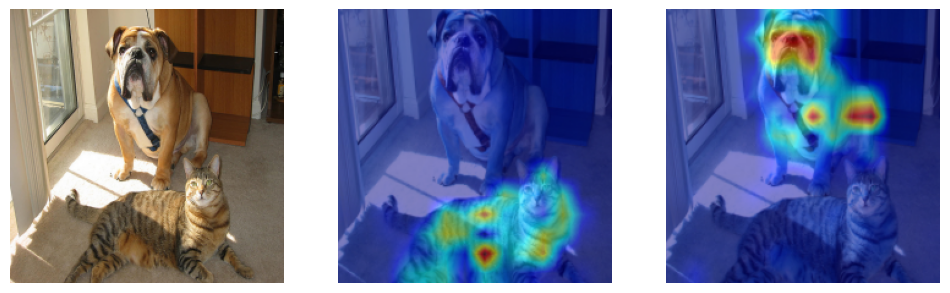

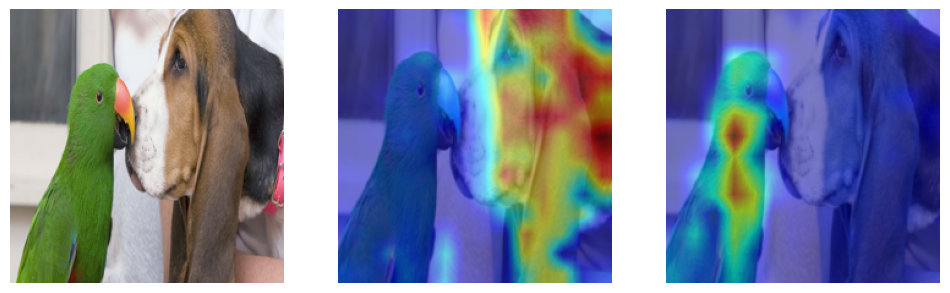

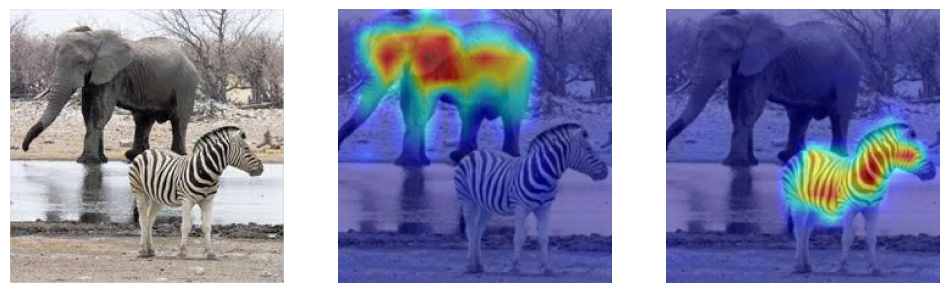

In [17]:
compare_indexes('samples/catdog.png', 243)
compare_indexes('samples/dogbird.png', 87)
compare_indexes('samples/el2.png', 340)

Top 5 classes:
	161 : basset, basset hound         		value = 10.514	 prob = 78.8%
	163 : bloodhound, sleuthhound      		value = 8.604	 prob = 11.7%
	166 : Walker hound, Walker foxhound		value = 7.446	 prob = 3.7%
	162 : beagle                       		value = 5.561	 prob = 0.6%
	168 : redbone                      		value = 5.249	 prob = 0.4%


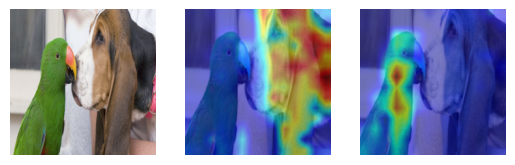